# Importar Librerias 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report,roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

# Cargar Data

In [ ]:
csv_path = "MercadoLibre Inc. Data Scientist Hiring Test - Fraud Dataset  - Data.csv" 
data = pd.read_csv(csv_path)

In [4]:
data.head(5)

,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,Monto,Fraude
0,0,10,50257.0,0,0,0.0,0.0,0,0,UY,...,0,3,1,0,5,0.00,0.00,7.25,37.51,1
1,0,10,29014.0,0,0,0.0,0.0,0,0,UY,...,0,1,1,0,3,0.00,0.00,11.66,8.18,1
2,0,7,92.0,0,1,0.0,0.0,0,1,UY,...,0,3,1,0,2,0.00,0.00,86.97,13.96,1
3,9,16,50269.0,0,0,0.0,0.0,0,0,UY,...,0,3,1,0,5,0.00,0.00,2.51,93.67,1
4,0,8,8180.0,0,0,0.0,0.0,0,0,UY,...,0,1,1,0,1,0.00,0.00,25.96,135.40,1


# Estructura del Dataset

Dimensión de la data

In [149]:
data.shape

(16880, 21)

Eliminación de las filas duplicadas

In [5]:
data = data.drop_duplicates().reset_index(drop=True)

In [6]:
# Dimensión de la tabla después de eliminar duplicados
data.shape

(16879, 21)

Exploración de la variable objetivo

In [7]:
y_FRAUD=data['Fraude']

In [153]:
num_1=data[data['Fraude']==1]['Fraude'].count()
num_0=data[data['Fraude']==0]['Fraude'].count()
print('''El número de registros los cuales se clasifican como fraudes son {}
El número de registros los cuales se clasifican como no fraudes son {}'''.format(num_1,num_0))

El número de registros los cuales se clasifican como fraudes son 4610
El número de registros los cuales se clasifican como no fraudes son 12269


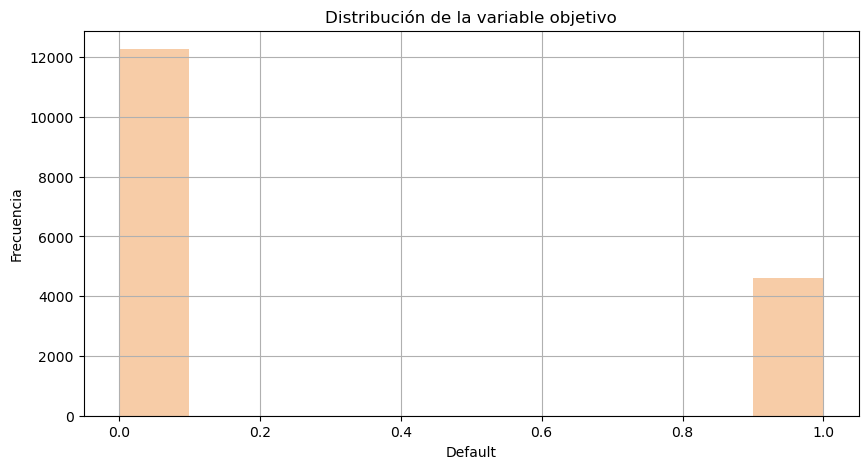

In [10]:
# plt.hist(data_at['TARGET'],alpha=0.6, edgecolor = 'blue',  linewidth=0.6,rwidth=0.85)
plt.figure(figsize=(10,5))
plt.hist(y_FRAUD,alpha=0.6, color='#F2AB6D')
plt.title('Distribución de la variable objetivo')
plt.xlabel('Default')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

De lo anterior, se observa que en los datos de entrenamiento hay un porcentaje mucho mayor de datos de la clase 0 que de la clase 1, lo cual es indicativo de un problema de clases desbalanceadas

In [11]:
print('''Porcentaje de datos de la clase 0: {}%
Porcentaje de datos de la clase 1: {}%'''.format(round(100*num_0/data.shape[0],2),round(100*num_1/data.shape[0],2)))

Porcentaje de datos de la clase 0: 72.69%
Porcentaje de datos de la clase 1: 27.31%


En el siguiente código se mostrará el nombre de la variable, la descripción de dicha columna, el tipo de variable, los valores que toma dicha variable y el número de elementos nulos en dicha columna (se debe tener en cuenta que los valores nulos en este caso, solo cuenta como los datos que tienen un tipo None, NaN).

In [8]:
# % Nulos
total = len(data)
percent_nulls = data.isnull().sum() / total * 100

# Tipo de variable y cantidad de nulos
summary = pd.DataFrame({
    'Tipo de variable': data.dtypes,
    'Cantidad de nulos': data.isnull().sum(),
    '% de Nulos': percent_nulls
}).reset_index().rename(columns={'index': 'Columna'})

print(summary)

   Columna Tipo de variable  Cantidad de nulos  % de Nulos
0        A            int64                  0    0.000000
1        B            int64                  0    0.000000
2        C          float64               3197   18.940696
3        D            int64                  0    0.000000
4        E            int64                  0    0.000000
5        F          float64                  0    0.000000
6        G          float64                  0    0.000000
7        H            int64                  0    0.000000
8        I            int64                  0    0.000000
9        J           object                  0    0.000000
10       K          float64              12863   76.207121
11       L            int64                  0    0.000000
12       M            int64                  0    0.000000
13       N            int64                  0    0.000000
14       O            int64                  0    0.000000
15       P            int64                  0    0.0000

La columna C tiene 3,197 valores nulos, un 18.9% del total de filas, lo que es significativo pero manejable para imputación.
La columna K presenta un 76.2% de valores nulos, que es una proporción muy alta respecto al total de registros del dataset.

Adicionalmente, podemos ver revisar la correlación con respecto a la variable objetivo para decidir que tratamiento hacerle a cada variable.

In [9]:
# Convertir columnas posibles a numéricas para análisis
for col in data.columns:
    if col not in ['K', 'Monto', 'Fraude']:
        try:
            data[col] = data[col].astype(str).str.replace(',', '').astype(float)
        except:
            continue

# Solo numéricas
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if 'Fraude' not in num_cols:
    num_cols.append('Fraude')

# Correlación Pearson
corrs = data[num_cols].corr()['Fraude'].drop('Fraude')

# Valores F y p de ANOVA (solo numéricas)
X = data[num_cols].drop(columns=['Fraude'], errors='ignore')
y = data['Fraude']
f_vals, p_vals = f_classif(X.fillna(X.median()), y)

# Guardar resumen
anovaf_df = pd.DataFrame({
    'Variable': X.columns,
    'F_value': f_vals,
    'p_value': p_vals,
    'Correlación con Fraude': corrs[X.columns].values
}).sort_values('F_value', ascending=False)

print(anovaf_df)

   Variable      F_value        p_value  Correlación con Fraude
1         B  1766.298829   0.000000e+00                0.307801
17        S  1036.572929  9.109589e-221                0.240552
14        P   339.275270   4.986059e-75                0.140380
9         K   287.109588   7.151271e-64               -0.248404
11        M   183.292906   1.525458e-41                0.103652
15        Q    96.425184   1.066126e-22                0.075372
12        N    70.494688   4.976905e-17                0.064495
7         H    70.238598   5.663745e-17                0.064378
2         C    47.189181   6.670494e-12                0.039320
16        R    21.854556   2.963924e-06                0.035962
0         A    19.750768   8.878810e-06                0.034189
13        O    13.262717   2.715471e-04                0.028022
10        L    12.489732   4.102892e-04                0.027194
4         E    11.560525   6.752282e-04                0.026163
5         F     6.867622   8.784999e-03 

La correlación entre K y la variable objetivo Fraude es de -0.25, lo cual indica una relación negativa moderada pero no necesariamente significativa para el modelado, considerando la gran cantidad de datos faltantes.

En conclusión, la variable K es candidata a ser eliminada porque:

Tiene un porcentaje muy alto de nulos (más del 76%), lo que podría generar ruido y afectar la calidad del modelo o requerir una imputación más avanzada.

Lo recomendado sería eliminar K , a menos que se tenga información de negocio que sugiera que es imprescindible para el análisis.

Para la variable C, vamos a mirar las estadisticas de manera que podamos saber cómo es la mejor forma de realizar la imputación.

In [10]:
data.C.describe()

count     13682.000000
mean      39238.080544
std       91048.015849
min           0.000000
25%        1172.000000
50%        6173.500000
75%       26891.250000
max      617324.000000
Name: C, dtype: float64

Sus estadísticas indican que es una variable numérica con:

Media alrededor de 39,235
Mediana (50%) mucho menor, 6,173, mostrando una distribución sesgada con valores atípicos altos.
Rango  de 0 a 617,324.

La correlación de C con Fraude es muy baja (0.039), lo que sugiere que no es un predictor fuerte por sí sola.

La mejor opción de imputación para C dada la distribución sesgada y la cantidad de nulos, lo más recomendable es imputar los valores faltantes con la mediana. La mediana es más robusta a los valores atípicos en distribuciones sesgadas en comparación con la media. Esto con el fin, de preservar la distribucuión sin distorsionar excesivamente la variable.

# Limpieza de los Datos

Se debe de tener en cuenta las siguientes recomendaciones:

-Asegurara que las columnas númericas esten en formato float on int.

-Asegurar que la variable monto contenga la  "," cómo separador de miles. (Para este ejercicio, solo se  requiere aplicar esta modificación a la variable Monto, pero en caso de que existan otras con las mismas carateríscicas, se debe de garantizar que esten en el formato correcto).

-Cambiar la variable Q y S a float

-Aplicar One Hot Encoding o Label Encoding a las categorías. (Para este caso, solo se modificará la variable "J", que hace referencia a países. Hay algunas variables que podrían ser categóricas, pero como no se tiene certeza, se trabajarán como variables numéricas)

-Normalizar o escalar variables númericas para mejorar el desempeño de los modelos.(Es importante escalar variables numéricas como monto cuando se usan modelos sensibles a magnitudes (como Regresión Logística, SVM, KNN o Redes Neuronales), ya que evita que una variable con mayor rango domine el modelo y afecte el rendimiento. El escalado mejora la estabilidad y la convergencia del entrenamiento. No es necesario en modelos basados en árboles como Random Forest o XGBoost.)

-Después del análisis exploratorio, se realizará la estandarización para facilitar la detección de posibles valores atípicos

In [11]:
def limpiar_dataset(path):
    # Cargar los datos
    df = data
    
    # Eliminar la columna 'K'
    df = df.drop(columns=['K'], errors='ignore')
 
    # Imputa con la mediana la columna 'C'
    df['C'] = df['C'].fillna(df['C'].median())
    
    # Convertir separador en Q, R y Monto
    for col in ['Q', 'R', 'Monto']:
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)
    
    # One hot encoding para J
    df = pd.get_dummies(df, columns=['J'], drop_first=True)
    ohe_cols = [col for col in df.columns if col.startswith('J_')]
    df[ohe_cols] = df[ohe_cols].astype(int)
    
    return df

In [12]:
df = limpiar_dataset(data)

In [13]:
pd.set_option('display.max_columns',None)

In [14]:
df.head()

,A,B,C,D,E,F,G,H,I,L,M,N,O,P,Q,R,S,Monto,Fraude,J_AU,J_BR,J_CA,J_CH,J_CL,J_CO,J_ES,J_FR,J_GB,J_GT,J_IT,J_KR,J_MX,J_PT,J_TR,J_UA,J_US,J_UY
0,0.0,10.0,50257.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,5.0,0.0,0.0,7.25,37.51,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.0,10.0,29014.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,11.66,8.18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.0,7.0,92.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0,86.97,13.96,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,9.0,16.0,50269.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,5.0,0.0,0.0,2.51,93.67,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.0,8.0,8180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,25.96,135.40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [15]:
# % Nulos
total = len(df)
percent_nulls = df.isnull().sum() / total * 100

# Tipo de variable y cantidad de nulos
summary = pd.DataFrame({
    'Tipo de variable': df.dtypes,
    'Cantidad de nulos': df.isnull().sum(),
    '% de Nulos': percent_nulls
}).reset_index().rename(columns={'index': 'Columna'})

print(summary)

   Columna Tipo de variable  Cantidad de nulos  % de Nulos
0        A          float64                  0         0.0
1        B          float64                  0         0.0
2        C          float64                  0         0.0
3        D          float64                  0         0.0
4        E          float64                  0         0.0
5        F          float64                  0         0.0
6        G          float64                  0         0.0
7        H          float64                  0         0.0
8        I          float64                  0         0.0
9        L          float64                  0         0.0
10       M          float64                  0         0.0
11       N          float64                  0         0.0
12       O          float64                  0         0.0
13       P          float64                  0         0.0
14       Q          float64                  0         0.0
15       R          float64                  0         0

# Análisis Exploratorio

Distribución de variables iniciales Fraude vS No Fraude

Estadisticas para el Monto

In [182]:
estadisticas = df.groupby('Fraude')['Monto'].describe()
print(estadisticas)

          count        mean         std   min    25%     50%      75%  \
Fraude                                                                  
0       12269.0  170.317791  267.802570  0.05  33.40  87.980  202.750   
1        4610.0  139.297948  293.871528  1.58  34.55  70.305  159.325   

             max  
Fraude            
0        5831.16  
1       12538.44  


Los montos en transacciones fraude son generalmente más bajos que en las no fraude, pero con una desviación estándar más alta y algunos montos máximos mucho mayores.

Gráficos de distribución Fraude VS No Fraude

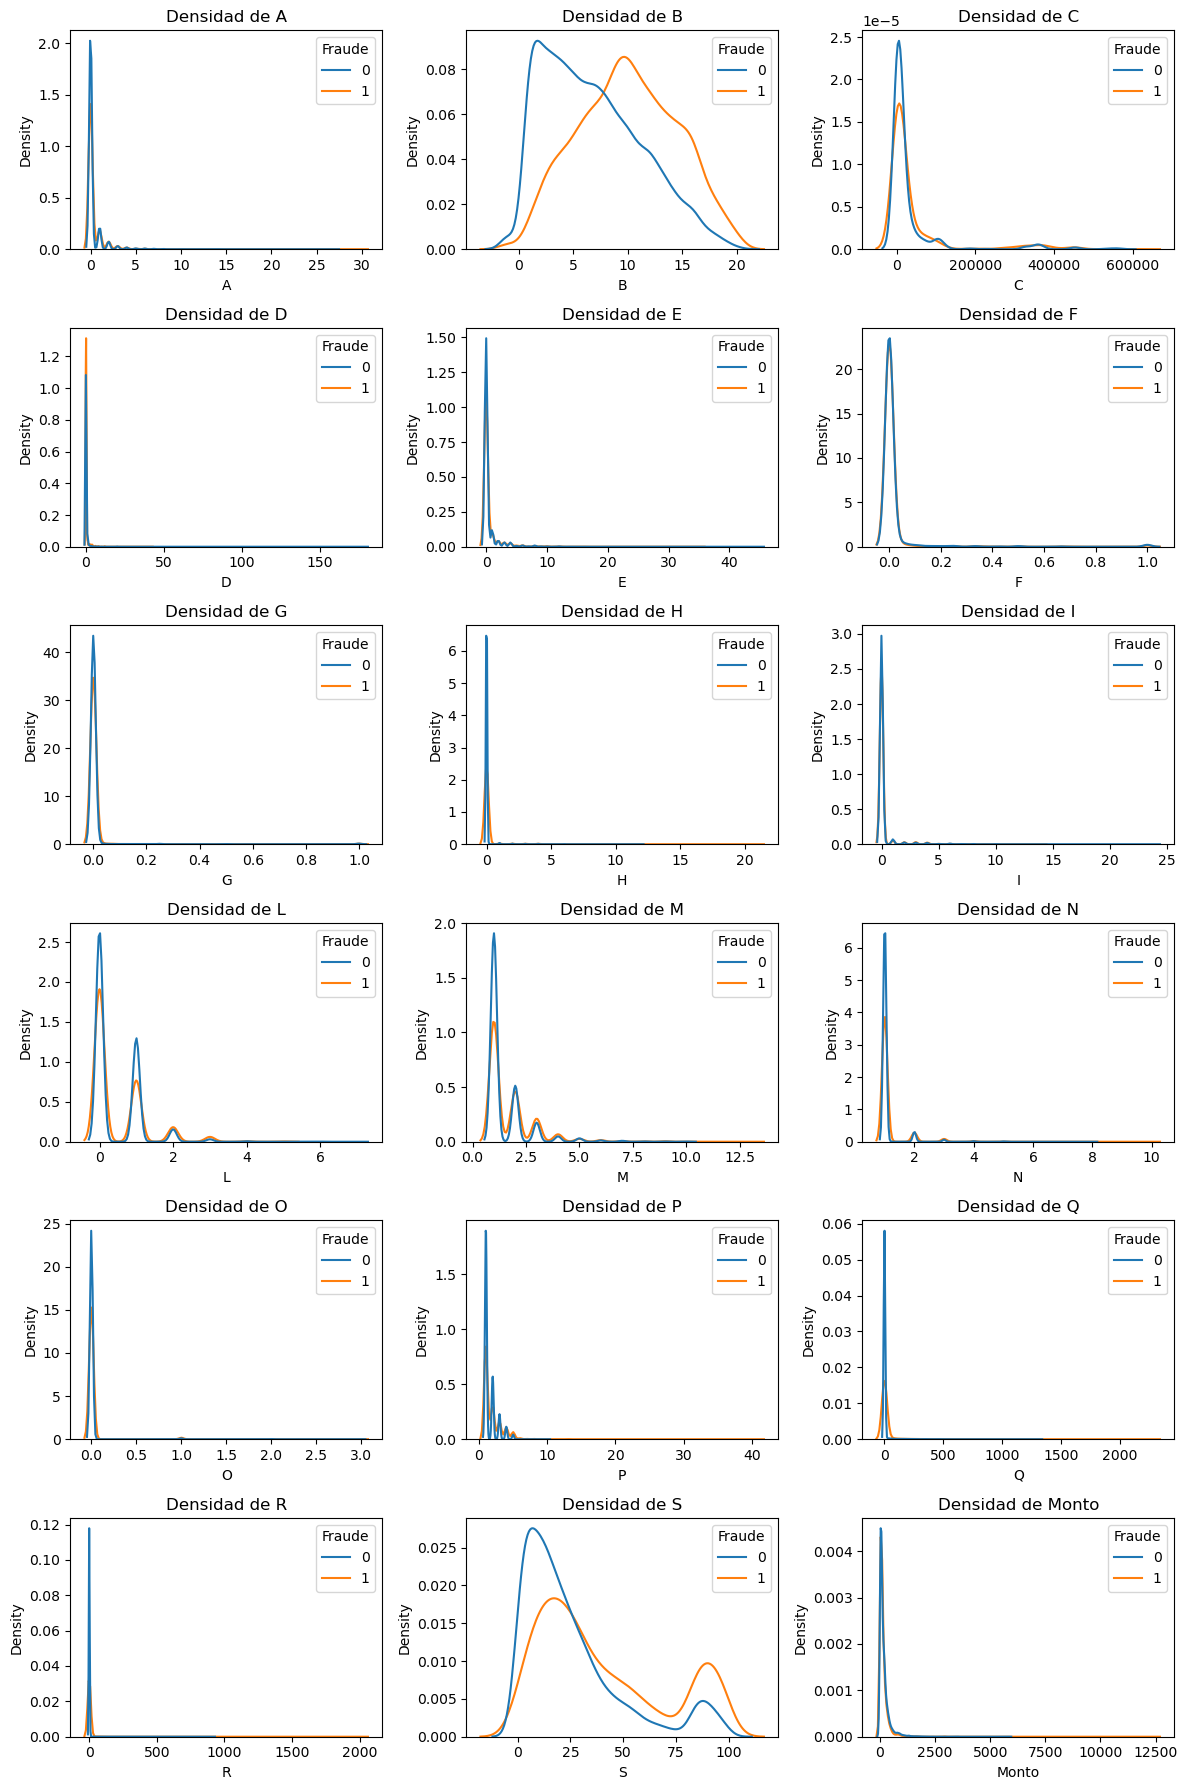

In [21]:
num_vars = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col not in ['Fraude', 'K']]
n = len(num_vars)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
axes = axes.flatten()

for i, col in enumerate(num_vars):
    sns.kdeplot(data=df, x=col, hue='Fraude', common_norm=False, ax=axes[i])
    axes[i].set_title(f'Densidad de {col}')

for i in range(n, len(axes)):
    fig.delaxes(axes[i])  # Eliminar subplots vacíos

plt.tight_layout()
plt.show()

Box Plot de Fraude VS No Fraude

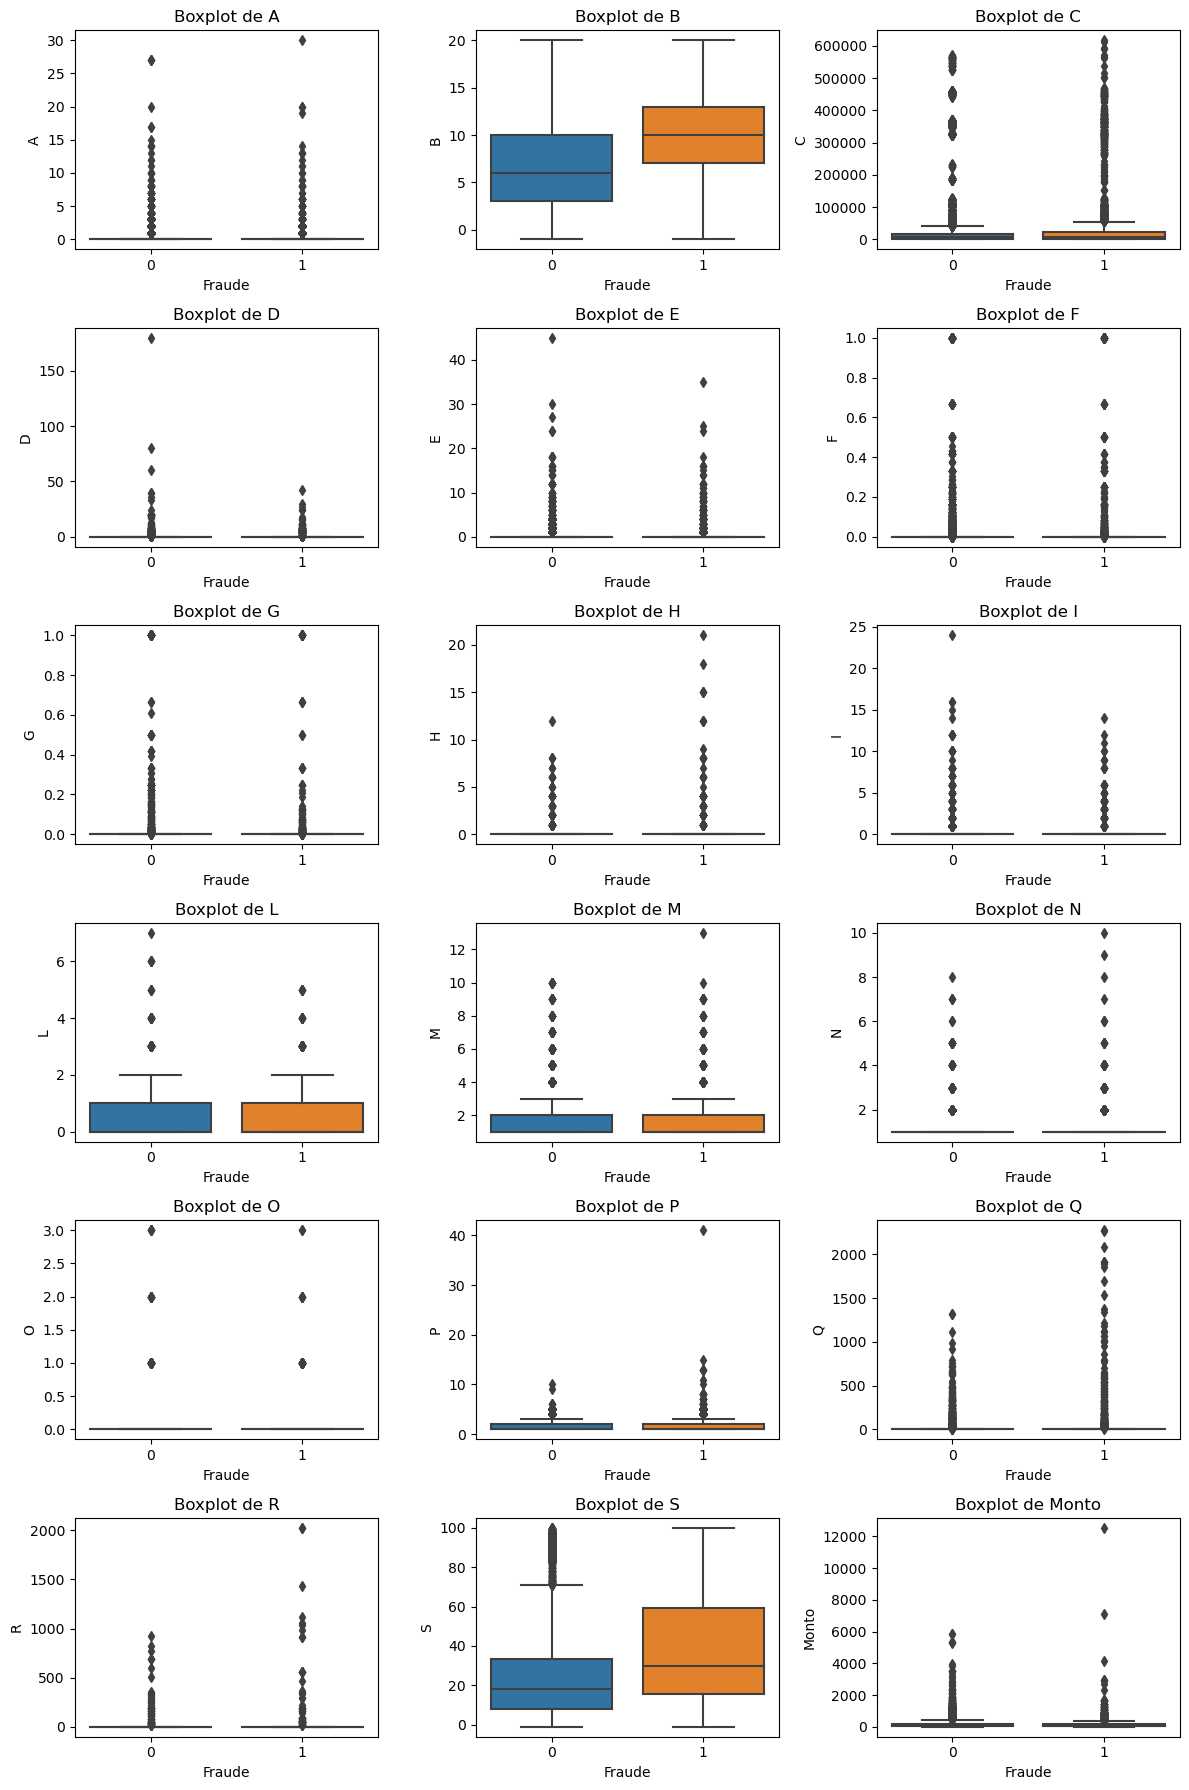

In [25]:
num_vars = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col != 'Fraude' and col != 'K']
n = len(num_vars)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
axes = axes.flatten()

for i, col in enumerate(num_vars):
    sns.boxplot(x='Fraude', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
for i in range(n, len(axes)):
    fig.delaxes(axes[i])  # Eliminar subplots vacíos

plt.tight_layout()
plt.show()

Distribución Variable Categórica 

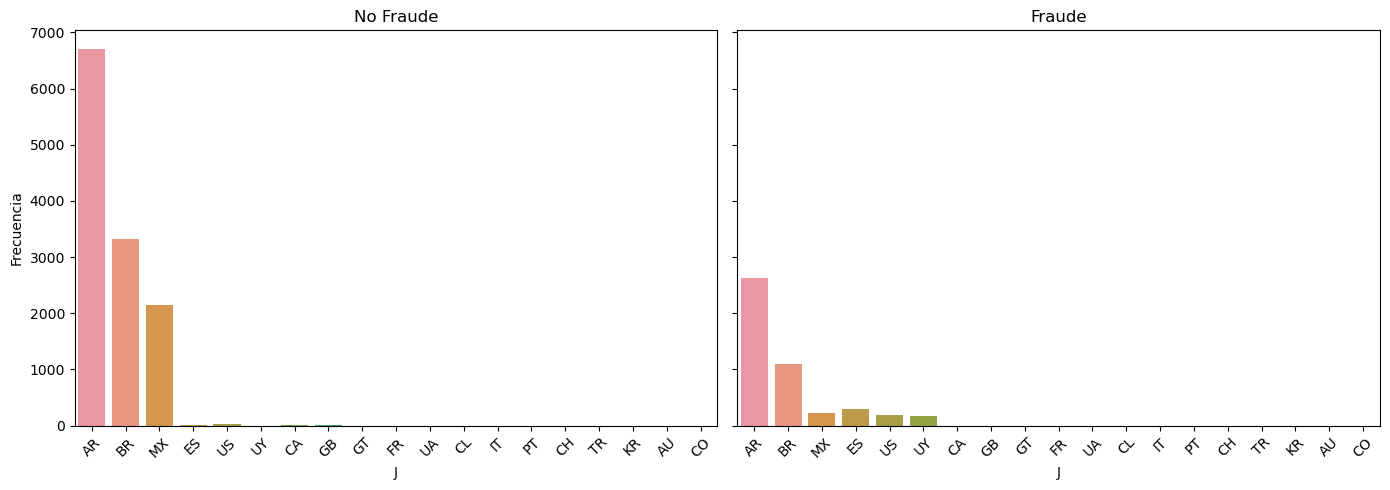

In [183]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# No fraude
sns.countplot(x='J', data=data[data['Fraude']==0], order=data['J'].value_counts().index, ax=axes[0])
axes[0].set_title('No Fraude')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xlabel('J')
axes[0].tick_params(axis='x', rotation=45)

# Fraude
sns.countplot(x='J', data=data[data['Fraude']==1], order=data['J'].value_counts().index, ax=axes[1])
axes[1].set_title('Fraude')
axes[1].set_ylabel('')
axes[1].set_xlabel('J')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

A partir de los gráficos anteriores, se pueden comenzar a formular hipótesis sobre cuáles son las variables que más discriminan al momento de detectar fraudes. Variables como B, S, P, J_ES, J_US y J_UY parecen ser relevantes, de manera similar a lo observado anteriormente en el análisis ANOVA F. Sin embargo, más adelante aplicaremos un método K-Best, que nos permitirá identificar con mayor precisión cuáles son las variables más influyentes.

# Valores Atípicos

Vamos a utilizar dos métodos estándar para identificar los outliers:

El método del rango intercuartílico (IQR), utilizando los cuantiles más comunes: 0.25 (Q1) y 0.75 (Q3).

La revisión de los datos que se encuentran por encima del percentil 99.

In [27]:

num_vars = df.select_dtypes(include=['float64', 'int64']).columns

outliers_dict = {}

for col in num_vars:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_lim) | (df[col] > upper_lim)]
    outliers_dict[col] = {
        'num_outliers': outliers.shape[0],
        'percent_outliers': 100 * outliers.shape[0] / len(df)
    }

for col, info in outliers_dict.items():
    print(f'{col}: {info["num_outliers"]} outliers ({info["percent_outliers"]:.2f}%)')

A: 2646 outliers (15.68%)
B: 0 outliers (0.00%)
C: 2519 outliers (14.92%)
D: 945 outliers (5.60%)
E: 2623 outliers (15.54%)
F: 1955 outliers (11.58%)
G: 455 outliers (2.70%)
H: 283 outliers (1.68%)
I: 882 outliers (5.23%)
L: 227 outliers (1.34%)
M: 780 outliers (4.62%)
N: 1113 outliers (6.59%)
O: 130 outliers (0.77%)
P: 1245 outliers (7.38%)
Q: 657 outliers (3.89%)
R: 132 outliers (0.78%)
S: 1581 outliers (9.37%)
Monto: 1214 outliers (7.19%)
Fraude: 0 outliers (0.00%)


In [28]:
num_vars = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col not in ['Fraude', 'K']]

outlier_counts = {}
for col in num_vars:
    p99 = df[col].quantile(0.99)
    count_outliers = (df[col] > p99).sum()
    outlier_counts[col] = count_outliers

for col, count in outlier_counts.items():
    print(f'{col}: {count} valores mayores al percentil 99')

A: 119 valores mayores al percentil 99
B: 161 valores mayores al percentil 99
C: 169 valores mayores al percentil 99
D: 142 valores mayores al percentil 99
E: 100 valores mayores al percentil 99
F: 149 valores mayores al percentil 99
G: 169 valores mayores al percentil 99
H: 124 valores mayores al percentil 99
I: 121 valores mayores al percentil 99
L: 41 valores mayores al percentil 99
M: 102 valores mayores al percentil 99
N: 86 valores mayores al percentil 99
O: 130 valores mayores al percentil 99
P: 56 valores mayores al percentil 99
Q: 169 valores mayores al percentil 99
R: 132 valores mayores al percentil 99
S: 169 valores mayores al percentil 99
Monto: 169 valores mayores al percentil 99


En ambos casos observamos que los dos métodos detectan datos fuera de los rangos establecidos. Sin embargo, dado que estamos analizando posibles fraudes, es recomendable conservar estos valores extremos, ya que podrían ser relevantes para identificar patrones anómalos y entrenar el modelo de manera adecuadametete, ya que pueden aportar información valiosa para la detección de fraudes. Como no tengo un conocimiento profundo del negocio, no puedo asegurar si se trata de errores de digitación o de eventos válidos pero poco frecuentes.

Para culminar la limpieza y transformación de los datos, vamos a escalar la variable Monto

In [16]:
scaler = RobustScaler()
df['Monto'] = scaler.fit_transform(df[['Monto']])

print(df['Monto'].head())

0   -0.276523
1   -0.460266
2   -0.424056
3    0.075301
4    0.336727
Name: Monto, dtype: float64


In [17]:
df.head(5)

,A,B,C,D,E,F,G,H,I,L,M,N,O,P,Q,R,S,Monto,Fraude,J_AU,J_BR,J_CA,J_CH,J_CL,J_CO,J_ES,J_FR,J_GB,J_GT,J_IT,J_KR,J_MX,J_PT,J_TR,J_UA,J_US,J_UY
0,0.0,10.0,50257.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,5.0,0.0,0.0,7.25,-0.276523,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.0,10.0,29014.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,11.66,-0.460266,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.0,7.0,92.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0,86.97,-0.424056,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,9.0,16.0,50269.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,5.0,0.0,0.0,2.51,0.075301,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.0,8.0,8180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,25.96,0.336727,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Una vez tenemos el datasaet con la limpieza y las transformaciones necesarias, vamos a revisar las correlaciones entre las variables númericas y a ver el nivel de importancia de las variables, basandonos en un k-best

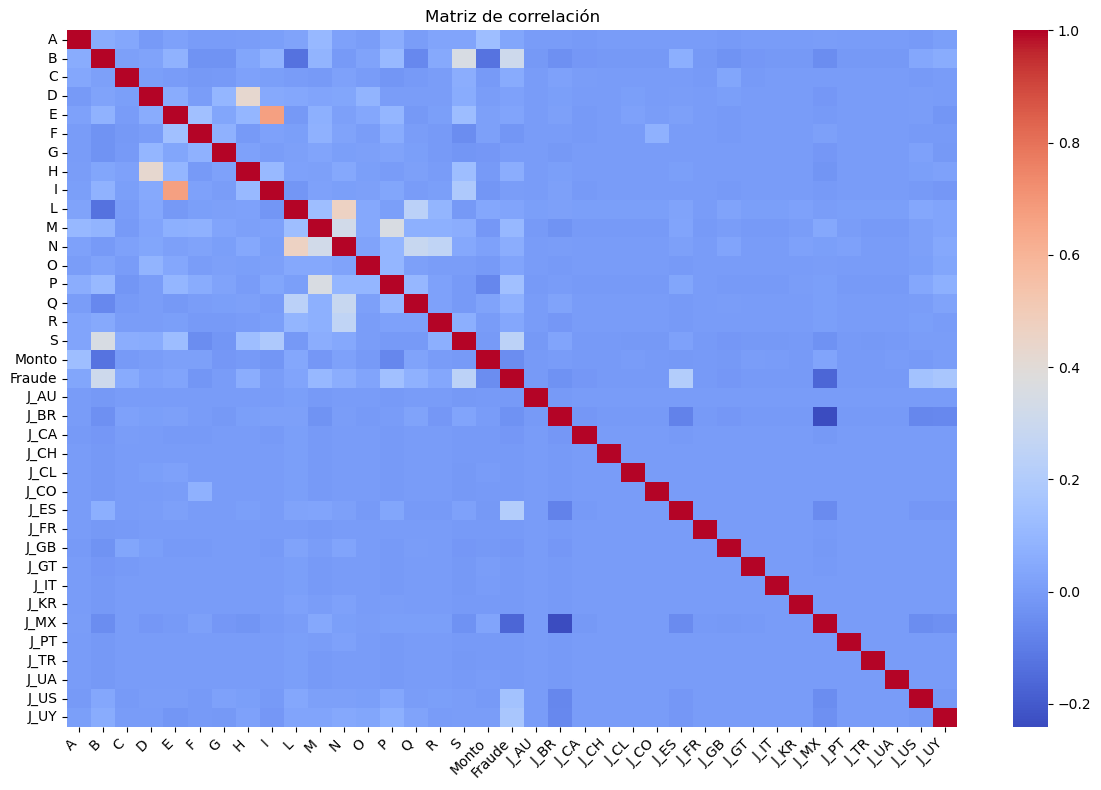

In [31]:
num = df.select_dtypes(include=[np.number]).drop(columns=['FRAUDE'], errors="ignore")
plt.figure(figsize=(12, 8))
sns.heatmap(
    num.corr(), cmap="coolwarm"
)
plt.title("Matriz de correlación")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

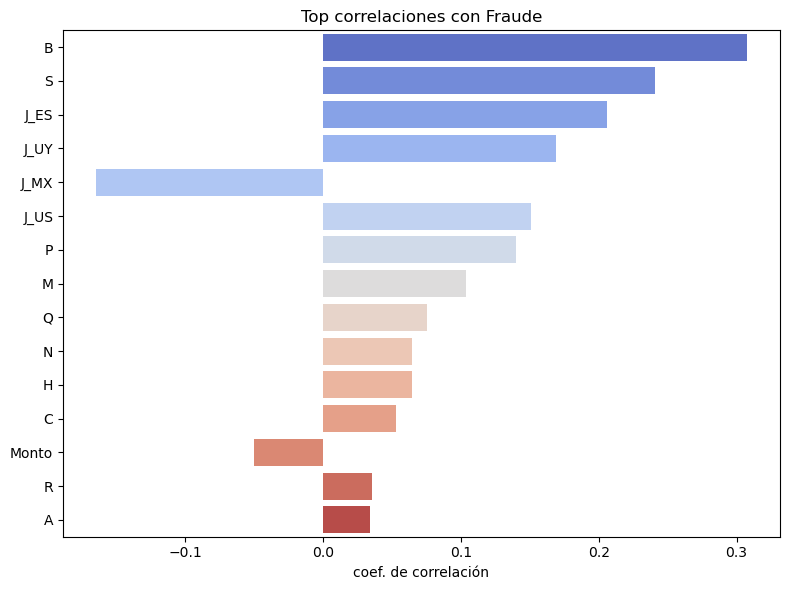

In [32]:
num_t = df.select_dtypes(include=[np.number]).copy()
tcorr = num_t.corr()['Fraude'].drop('Fraude')
top = tcorr.reindex(tcorr.abs().sort_values(ascending=False).head(15).index)

plt.figure(figsize=(8, 6))
sns.barplot(x=top.values, y=top.index, palette="coolwarm")
plt.title(f"Top correlaciones con {'Fraude'}")
plt.xlabel("coef. de correlación")
plt.ylabel("")
plt.tight_layout()
plt.show()

Importancia de las variables

In [24]:
# Definir X (variables predictoras) y (objetivo)
y = df['Fraude']
num_vars = [col for col in df.select_dtypes(include=[float, int]).columns if col not in ['Fraude']]
X = df[num_vars].fillna(df[num_vars].median())

selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)
selected_vars = [num_vars[i] for i in selector.get_support(indices=True)]
scores = selector.scores_
p_selected = scores[selector.get_support(indices=True)]

resultados = pd.DataFrame({'Variable': selected_vars, 'F_Score': p_selected}).sort_values('F_Score', ascending=False)
print(resultados)

  Variable      F_Score
0        B  1766.298829
5        S  1036.572929
6     J_ES   747.244857
9     J_UY   498.455603
7     J_MX   470.985198
8     J_US   394.289637
3        P   339.275270
1        M   183.292906
4        Q    96.425184
2        N    70.494688


# Modelado

In [18]:
df['Fraude']=df['Fraude'].astype('category')
df['Fraude'].dtype 

CategoricalDtype(categories=[0, 1], ordered=False)

Balance de Bases

Como observamos anteriormente, las clases están desbalanceadas. Por ello, aplicaremos dos técnicas de balanceo y compararemos cuál ofrece mejores resultados.

a. Submuestreo (undersampling) de la clase mayoritaria
b. SMOTE: Creación de datos sintéticos de la case minoritaria

a. Submuestreo

In [41]:
from collections import Counter

Se crea un pipeline que permite realizar el submuestreo únicamente sobre la base de entrenamiento, analizar diferentes modelos (Regresión Logística, Random Forest, SVM, XGBoost) y obtener las métricas más relevantes. Esto facilita la elección del modelo más adecuado, sobre el cual se podrán realizar ajustes posteriores.

In [36]:
# Separar features y variable objetivo
def get_feature_and_target(df):
   X = df.drop("Fraude", axis=1)
   y= df["Fraude"]
   return X, y

# Division train-test
def dividir(X, y, test_size=0.3):
  return train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

def balancear_data(X_train, y_train, ratio=1.0):
# Submuestrear clase mayoritaria
  df_balanceada = RandomUnderSampler(sampling_strategy=ratio, random_state=42)
  X_bal, y_bal = df_balanceada.fit_resample(X_train, y_train)
  return  X_bal , y_bal

def entrenar_y_evaluar(modelo, X_bal, y_bal, X_val, y_val):
    modelo.fit(X_bal, y_bal)
    y_pred = modelo.predict(X_val)
    
    # Probabilidades para ROC/AUC
    # Algunos modelos usan predict_proba (todos excepto SVM), SVM utiliza decision_function
    if hasattr(modelo, "predict_proba"):
        y_score = modelo.predict_proba(X_val)[:, 1]
    elif hasattr(modelo, "decision_function"):
        y_score = modelo.decision_function(X_val)
    else:
        # Si el modelo no tiene ninguna, usa las predicciones de clase (menos recomendado)
        y_score = y_pred

    auc = roc_auc_score(y_val, y_score)
    fpr, tpr, thresholds = roc_curve(y_val, y_score)

    return {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1_score': f1_score(y_val, y_pred),
        'auc': auc,
        'roc_curve': (fpr, tpr, thresholds),
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'classification_report': classification_report(y_val, y_pred)
    }

def pipeline_fraude(df):
    X, y = get_feature_and_target(df)
    X_train, X_val, y_train, y_val = dividir(X, y)
    X_bal, y_bal = balancear_data(X_train,y_train)

    modelos = {
        'Regresión Logistica': LogisticRegression(max_iter=200, solver='liblinear', C=0.1),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'SVM': SVC(probability=True, random_state=42),
        'XGBoost': XGBClassifier(eval_metric='logloss')
    }
    
    resultados = {}
    for nombre, modelo in modelos.items():
        resultados[nombre] = entrenar_y_evaluar(modelo, X_bal, y_bal, X_val, y_val)
    return resultados

Métricas de los modelos

In [37]:
resultados_fraude =  pipeline_fraude(df)

# Para imprimir resultados de manera clara
for nombre, metrics in resultados_fraude.items():
    print(f"Modelo: {nombre}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precisión: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1_score']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")
    fpr, tpr, thresholds = metrics['roc_curve']
    print("Matriz de confusión:")
    print(metrics['confusion_matrix'])
    print("Reporte de clasificación:")
    print(metrics['classification_report'])
    print("="*50)

Modelo: Regresión Logistica
Accuracy: 0.6501
Precisión: 0.4228
Recall: 0.7708
F1-Score: 0.5461
AUC: 0.7604
Matriz de confusión:
[[2226 1455]
 [ 317 1066]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.60      0.72      3681
           1       0.42      0.77      0.55      1383

    accuracy                           0.65      5064
   macro avg       0.65      0.69      0.63      5064
weighted avg       0.75      0.65      0.67      5064

Modelo: Random Forest
Accuracy: 0.7275
Precisión: 0.5007
Recall: 0.7368
F1-Score: 0.5963
AUC: 0.8131
Matriz de confusión:
[[2665 1016]
 [ 364 1019]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.72      0.79      3681
           1       0.50      0.74      0.60      1383

    accuracy                           0.73      5064
   macro avg       0.69      0.73      0.70      5064
weighted avg       0.78      0.73      0.74  

Ahora vamos a realizar el mismo ejercicio realizando la técnica SMOTE y según los valores podemos decirdir cual método es mejor.

b. SMOTE

In [184]:
X = df.drop("Fraude", axis=1)
y= df["Fraude"]

In [185]:
mm=train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [186]:
smote = SMOTE(random_state=42)
X_smot, y_smot = smote.fit_resample(X_train, y_train)


In [190]:
X_smot.shape

(17176, 36)

In [19]:
# Separar features y variable objetivo
def get_feature_and_target(df):
   X = df.drop("Fraude", axis=1)
   y= df["Fraude"]
   return X, y

# Division train-test
def dividir(X, y, test_size=0.3):
  return train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

def balancear_data(X_train, y_train, ratio=1.0):
# Submuestrear clase mayoritaria
  smote = SMOTE(random_state=42)
  X_smot, y_smot = smote.fit_resample(X_train, y_train)
  return  X_smot , y_smot

def entrenar_y_evaluar(modelo, X_smot, y_smot, X_val, y_val):
    modelo.fit(X_smot, y_smot)
    y_pred = modelo.predict(X_val)
    
    # Probabilidades para ROC/AUC
    # Algunos modelos usan predict_proba (todos excepto SVM), SVM utiliza decision_function
    if hasattr(modelo, "predict_proba"):
        y_score = modelo.predict_proba(X_val)[:, 1]
    elif hasattr(modelo, "decision_function"):
        y_score = modelo.decision_function(X_val)
    else:
        # Si el modelo no tiene ninguna, usa las predicciones de clase (menos recomendado)
        y_score = y_pred

    auc = roc_auc_score(y_val, y_score)
    fpr, tpr, thresholds = roc_curve(y_val, y_score)

    return {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1_score': f1_score(y_val, y_pred),
        'auc': auc,
        'roc_curve': (fpr, tpr, thresholds),
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'classification_report': classification_report(y_val, y_pred)
    }

def pipeline_fraude_smot(df):
    X, y = get_feature_and_target(df)
    X_train, X_val, y_train, y_val = dividir(X, y)
    X_smot, y_smot = balancear_data(X_train,y_train)

    modelos = {
        'Regresión Logistica': LogisticRegression(max_iter=200, solver='liblinear', C=0.1),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'SVM': SVC(probability=True, random_state=42),
        'XGBoost': XGBClassifier(eval_metric='logloss')
    }
    
    resultados = {}
    for nombre, modelo in modelos.items():
        resultados[nombre] = entrenar_y_evaluar(modelo, X_smot, y_smot, X_val, y_val)
    return resultados

In [20]:
resultados_fraude_smote =  pipeline_fraude_smot(df)

# Para imprimir resultados de manera clara
for nombre, metrics in resultados_fraude_smote.items():
    print(f"Modelo: {nombre}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precisión: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1_score']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")
    fpr, tpr, thresholds = metrics['roc_curve']
    print("Matriz de confusión:")
    print(metrics['confusion_matrix'])
    print("Reporte de clasificación:")
    print(metrics['classification_report'])
    print("="*50)

Modelo: Regresión Logistica
Accuracy: 0.5308
Precisión: 0.3507
Recall: 0.8431
F1-Score: 0.4953
AUC: 0.7133
Matriz de confusión:
[[1522 2159]
 [ 217 1166]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.41      0.56      3681
           1       0.35      0.84      0.50      1383

    accuracy                           0.53      5064
   macro avg       0.61      0.63      0.53      5064
weighted avg       0.73      0.53      0.54      5064

Modelo: Random Forest
Accuracy: 0.7873
Precisión: 0.6335
Recall: 0.5249
F1-Score: 0.5741
AUC: 0.8134
Matriz de confusión:
[[3261  420]
 [ 657  726]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3681
           1       0.63      0.52      0.57      1383

    accuracy                           0.79      5064
   macro avg       0.73      0.71      0.72      5064
weighted avg       0.78      0.79      0.78  

# Decisión del mejor modelo
Después de analizar las métricas, concluimos que la mejor técnica es el submuestreo, ya que al aplicar SMOTE sobre los datos, las métricas muestran una disminución. Adicionalmente, el mejor modelo es XGBoost. Por lo tanto, realizaremos ajustes en sus hiperparámetros para evaluar si el rendimiento mejora. Finalmente, procederemos a realizar un análisis económico.

# Mejora del modelo y análisis económico

In [60]:
X = df.drop("Fraude", axis=1)
y= df["Fraude"]
train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
df_balanceada = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_bal, y_bal = df_balanceada.fit_resample(X_train, y_train)

In [61]:
model_XGBoost= XGBClassifier(eval_metric='logloss')
model_XGBoost.fit(X_bal, y_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [62]:
y_pred = model_XGBoost.predict(X_test)

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Matriz de confusión:
[[2700  981]
 [ 363 1020]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      3681
           1       0.51      0.74      0.60      1383

    accuracy                           0.73      5064
   macro avg       0.70      0.74      0.70      5064
weighted avg       0.78      0.73      0.75      5064



In [64]:
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precisión: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1-Score: {metrics['f1_score']:.4f}")
print(f"AUC: {metrics['auc']:.4f}")

Accuracy: 0.7346
Precisión: 0.5097
Recall: 0.7375
F1-Score: 0.6028
AUC: 0.8164


In [70]:
y_pred2=model_XGBoost.predict_proba(X_test)[:, 1]

In [71]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

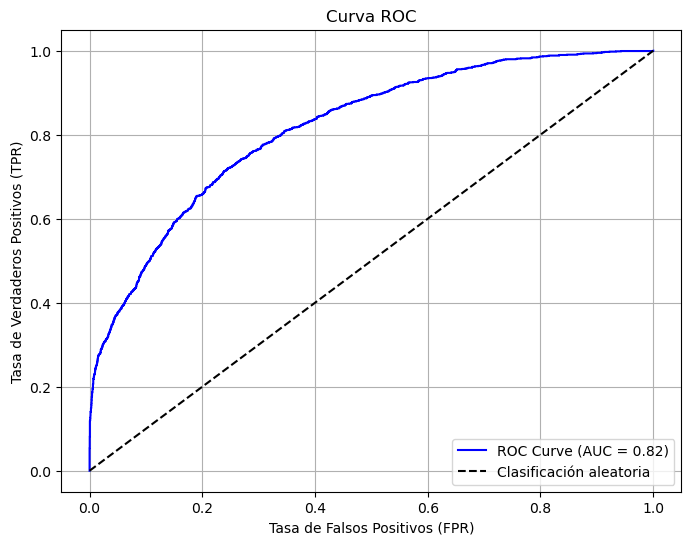

In [72]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificación aleatoria')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

J_MX    0.203146
J_UY    0.125031
J_ES    0.124455
J_US    0.102537
B       0.059786
H       0.033851
Q       0.031998
P       0.026830
S       0.025276
J_BR    0.025163
dtype: float32


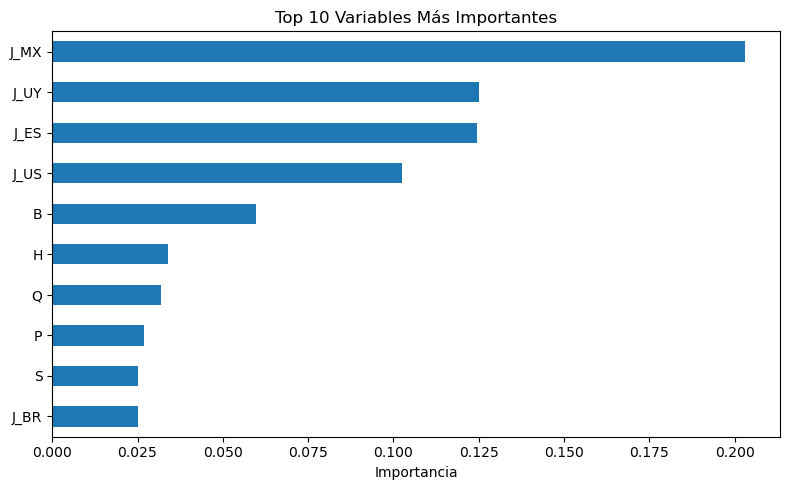

In [73]:

importancia = pd.Series(model_XGBoost.feature_importances_, index=X_bal.columns)
importancia = importancia.sort_values(ascending=False)

# Ver las 10 variables más importantes
print(importancia.head(10))

# Graficar
importancia.head(10).plot(kind='barh', title='Top 10 Variables Más Importantes', figsize=(8, 5))
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

# Ajuste de hiperparámetros

In [83]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [85]:
# Dividir datos
X_train_, X_val, y_train_, y_val = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)

In [86]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
    }

    dtrain = xgb.DMatrix(X_train_, label=y_train_)
    dval = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(params, dtrain, num_boost_round=100,
                      evals=[(dval, 'validation')],
                      early_stopping_rounds=10,
                      verbose_eval=False)

    preds = model.predict(dval)
    auc = roc_auc_score(y_val, preds)
    return auc

# Ejecutar búsqueda
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Mejores parámetros encontrados:")
print(study.best_params)

[I 2025-10-17 03:39:00,131] A new study created in memory with name: no-name-9fe59bd8-f371-42fa-859a-1e96510e4353
[I 2025-10-17 03:39:01,027] Trial 0 finished with value: 0.8111739564405089 and parameters: {'learning_rate': 0.21498017704337163, 'max_depth': 4, 'subsample': 0.6383688295474493, 'colsample_bytree': 0.9837839014223632, 'gamma': 0.5182806523699829, 'reg_alpha': 1.311529277191894, 'reg_lambda': 1.4171778864916618}. Best is trial 0 with value: 0.8111739564405089.
[I 2025-10-17 03:39:01,574] Trial 1 finished with value: 0.8034960202697515 and parameters: {'learning_rate': 0.18032792148516022, 'max_depth': 10, 'subsample': 0.6726299996356258, 'colsample_bytree': 0.5250340656157912, 'gamma': 4.637943309723751, 'reg_alpha': 0.6673158882380026, 'reg_lambda': 2.0183818630699477}. Best is trial 0 with value: 0.8111739564405089.
[I 2025-10-17 03:39:02,300] Trial 2 finished with value: 0.806297933782066 and parameters: {'learning_rate': 0.12960302963129663, 'max_depth': 4, 'subsample'

Mejores parámetros encontrados:
{'learning_rate': 0.15747282571361046, 'max_depth': 6, 'subsample': 0.8392724004988417, 'colsample_bytree': 0.594653756980464, 'gamma': 0.7283793835582978, 'reg_alpha': 3.128256040862251, 'reg_lambda': 0.43700323576311384}


In [88]:
best_params = study.best_params  

final_model = XGBClassifier(**best_params, eval_metric='logloss')
final_model.fit(X_bal, y_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.594653756980464, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.7283793835582978, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15747282571361046,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [94]:
y_pred3 = final_model.predict(X_test)
y_proba3 = final_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred3))
print("AUC:", roc_auc_score(y_test, y_proba3))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80      3681
           1       0.51      0.75      0.61      1383

    accuracy                           0.73      5064
   macro avg       0.70      0.74      0.70      5064
weighted avg       0.78      0.73      0.75      5064

AUC: 0.8258099918225402


In [95]:
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred3))

Matriz de confusión:
[[2670 1011]
 [ 340 1043]]


In [115]:
auc = roc_auc_score(y_test, y_proba3)

In [116]:
print(auc)

0.8258099918225402


In [117]:
print(f"Accuracy: {accuracy_score(y_test, y_pred3)}")
print(f"Precisión: {precision_score(y_test, y_pred3)}")
print(f"Recall: {recall_score(y_test, y_pred3)}")
print(f"F1-Score: {f1_score(y_test, y_pred3)}")
print(f"AUC: {roc_auc_score(y_test, y_proba3)}")


Accuracy: 0.733214849921011
Precisión: 0.5077896786757546
Recall: 0.7541576283441793
F1-Score: 0.6069246435845214
AUC: 0.8258099918225402


In [104]:
y_pred4=final_model.predict_proba(X_test)[:, 1]

In [105]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba3)
auc_score = roc_auc_score(y_test, y_proba3)

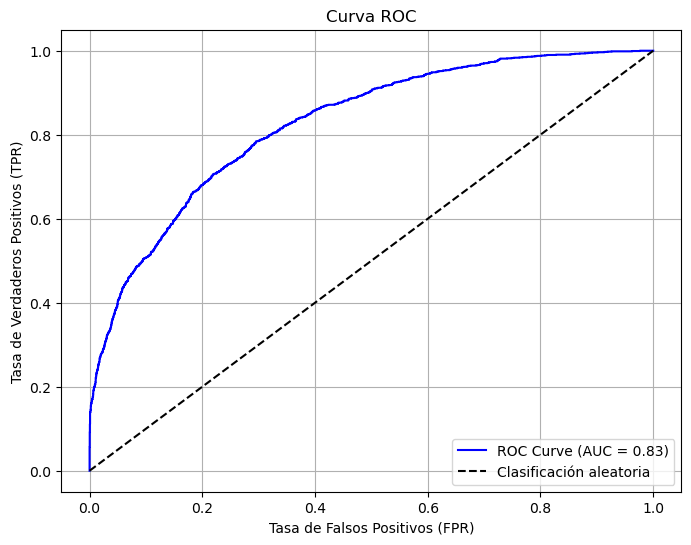

In [106]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificación aleatoria')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [140]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba3)

# Calcular F1-score para cada threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

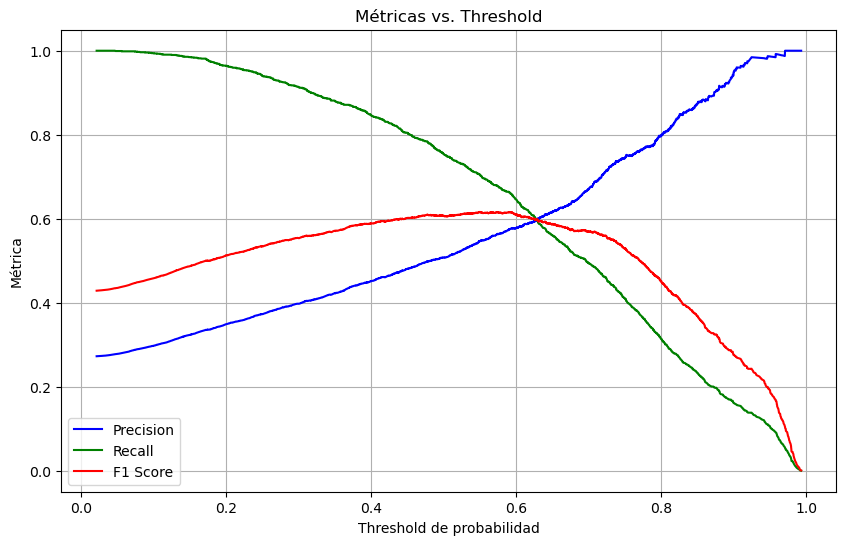

In [122]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='red')
plt.xlabel('Threshold de probabilidad')
plt.ylabel('Métrica')
plt.title('Métricas vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [141]:
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Mejor threshold según F1: {round(best_threshold, 3)}")

Mejor threshold según F1: 0.550000011920929


In [142]:
# Clasificar con un threshold personalizado
y_pred_custom = (y_proba3 >= best_threshold).astype(int)

# Evaluar
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      3681
           1       0.55      0.70      0.62      1383

    accuracy                           0.76      5064
   macro avg       0.71      0.74      0.72      5064
weighted avg       0.79      0.76      0.77      5064



In [143]:
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_custom ))

Matriz de confusión:
[[2876  805]
 [ 408  975]]


In [144]:
# y_test: reales
# y_pred: predicciones del modelo
cm = confusion_matrix(y_test, y_pred_custom)

TN, FP, FN, TP = cm.ravel()

# Parámetros económicos
ganancia_legitima = 0.25   # +25%
perdida_fraude = -1.0      # -100%

# Cálculo de ganancia económica total
ganancia_total = (TN * ganancia_legitima) + (FN * perdida_fraude)

print("Ganancia económica total:", ganancia_total)

Ganancia económica total: 311.0


In [145]:
TN, FP, FN, TP = cm.ravel()

print(f"TN: {TN}")
print(f"FP: {FP}")
print(f"FN: {FN}")
print(f"TP: {TP}")

TN: 2876
FP: 805
FN: 408
TP: 975


In [146]:

# Parámetros económicos
ganancia_legitima = 0.25   # +25%
perdida_fraude = -1.0      # -100%

# Cálculo de ganancia económica total
ganancia_total = (TN * ganancia_legitima) + (FN * perdida_fraude)

print("Ganancia económica total:", ganancia_total)

Ganancia económica total: 311.0


Los resultados de las métricas muestras que al ajustar el modelo obtenido tiene mejor capacidad predictiva.

# Evaluación de métricas económicas

In [118]:
# y_test: reales
# y_pred: predicciones del modelo
cm = confusion_matrix(y_test, y_pred3)

TN, FP, FN, TP = cm.ravel()

# Parámetros económicos
ganancia_legitima = 0.25   # +25%
perdida_fraude = -1.0      # -100%

# Cálculo de ganancia económica total
ganancia_total = (TN * ganancia_legitima) + (FN * perdida_fraude)

print("Ganancia económica total:", ganancia_total)

Ganancia económica total: 327.5


El umbral óptimo es: 0.39
La ganancia máxima esperada es: 356.75


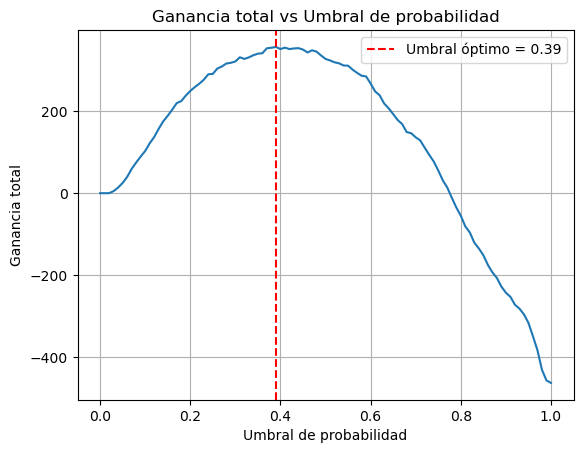

In [132]:
# y_test: etiquetas reales
# y_proba: probabilidades predichas por el modelo para clase 1 (fraude)

ganancia_legitima = 0.25  # +25%
perdida_fraude = -1.0     # -100%

# Rango de umbrales para evaluar
thresholds = np.linspace(0, 1, 101)

ganancias = []

for threshold in thresholds:
    # Clasificación con el threshold actual
    y_pred5 = (y_proba3 >= threshold).astype(int)
    
    # Matriz de confusión
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred5).ravel()
    
    # Ganancia total según tus valores
    ganancia_total = (TN * ganancia_legitima) + (FN * perdida_fraude)
    ganancias.append(ganancia_total)

# Obtener el mejor umbral y la ganancia máxima
best_idx = np.argmax(ganancias)
best_threshold = thresholds[best_idx]
best_ganancia = ganancias[best_idx]

print(f"El umbral óptimo es: {best_threshold:.2f}")
print(f"La ganancia máxima esperada es: {best_ganancia:.2f}")

# Opcional: graficar ganancia vs umbral
import matplotlib.pyplot as plt

plt.plot(thresholds, ganancias)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Umbral óptimo = {best_threshold:.2f}')
plt.xlabel('Umbral de probabilidad')
plt.ylabel('Ganancia total')
plt.title('Ganancia total vs Umbral de probabilidad')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
# Clasificar con un threshold personalizado
y_pred_custom = (y_proba3 >= best_threshold).astype(int)

# Evaluar
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.92      0.60      0.73      3681
           1       0.45      0.86      0.59      1383

    accuracy                           0.67      5064
   macro avg       0.68      0.73      0.66      5064
weighted avg       0.79      0.67      0.69      5064



In [135]:
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_custom ))

Matriz de confusión:
[[2215 1466]
 [ 197 1186]]


In [137]:
# Obtener la matriz de confusión
cm = confusion_matrix(y_test, y_pred_custom)

# cm es una matriz 2x2:
# [[TN, FP],
#  [FN, TP]]

TN, FP, FN, TP = cm.ravel()

print(f"TN: {TN}")
print(f"FP: {FP}")
print(f"FN: {FN}")
print(f"TP: {TP}")

TN: 2215
FP: 1466
FN: 197
TP: 1186


In [138]:
sensibilidad = TP / (TP + FN) if (TP + FN) > 0 else 0
especificidad = TN / (TN + FP) if (TN + FP) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
exactitud = (TP + TN) / (TP + TN + FP + FN)
f1_score = 2 * (precision * sensibilidad) / (precision + sensibilidad) if (precision + sensibilidad) > 0 else 0

print(f"Sensibilidad (Recall): {sensibilidad:.4f}")
print(f"Especificidad: {especificidad:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Exactitud (Accuracy): {exactitud:.4f}")
print(f"F1-Score: {f1_score:.4f}")

Sensibilidad (Recall): 0.8576
Especificidad: 0.6017
Precisión: 0.4472
Exactitud (Accuracy): 0.6716
F1-Score: 0.5879


Con los valores observados en las métricas después de ajustar el umbral, podemos concluir que se mejora aquello que es prioritario en este caso: se maximizan las ganancias y se incrementa el recall, lo que permite detectar una mayor cantidad de fraudes. Aunque el F1-score disminuye ligeramente, se mantiene en niveles aceptables.

Es importante destacar que, al aumentar el recall, la precisión suele disminuir. Sin embargo, en este ejercicio es un compromiso válido, ya que nuestro objetivo principal es aumentar la detección de fraudes. Además, al mantenerse el F1-score en valores razonables, seguimos conservando un buen equilibrio entre precisión y sensibilidad.